# TD-IDF BASELINE
two baselines:
1. response is a document 
2. task is a document
    * 1-nn
    * centroid-nn

### evaluation
1. TC as classification
    * [x] cls report
    * [x] confusion matrix
    * [x] kappa
2. TC as regression
    * [x] MAE
    * [x] correlation
    * [x] prediction plot
3. Clusters
    * [x] task clusters
    * [x] bin clusters
    * [x] bin cluster distances

In [31]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
import numpy as np
import eval_utils

In [2]:
df = pd.read_csv("../../data/finnish_average.csv")

# TF-IDF
* task is a doc
    * mean of closests train responses
    * closest score bin

1. [x] fit a vectorizer on everything but test fold responses
2. [x] transform test fold responses
3. [x] get closest train vectors

In [3]:
def tok(text):
    """
    Whitespace tokenizes
    """
    
    tokenized_text = text.split(' ')
    return tokenized_text

def get_task_docs(df, transcript_column):
    """
    Returns task reponses as one task document
    """
    
    task_docs = []
    for task in df['task'].unique():
        task_transctipts = df[df['task']==task][transcript_column].tolist()
        task_doc = " ".join(task_transctipts)
        task_docs.append(task_doc)
    
    return task_docs


def get_mean_score_by_fold(train_df, test_df, transcript_column_train, 
                           transcript_column_test, criterion, n=1, task_w=True):

    """
    Computes the mean score for each task in the test dataset 
    based on the nearest matches in the training dataset using TF-IDF vectors of the transcript columns

    Parameters
    ----------
    train_df, test_df : DataFrame
        Training and testing datasets
    transcript_column_train, transcript_column_test : str
        Names of the transcript columns in the training and test datasets
    criterion : str
        Column name with criterion scores
    n : int, optional
        Number of closest responses considered for mean score
    task_w : bool, optional
        If True, idf is based on all resposes in a task as one document

    Returns
    -------
    y_pred : list
        Predicted mean scores
    y_true : list
        Actual criterion values from the test dataset
    sample_to_pred : dict
        Dictionary mapping test samples to predicted mean score
    """

    train_df.reset_index(drop=True, inplace=True)
    test_df.reset_index(drop=True, inplace=True)
    
    y_pred = []
    sample_to_pred = {}
    
    test_samples = test_df['sample'].tolist()
    
    if task_w:
        # if idf computed per task
        task_docs = get_task_docs(train_df, transcript_column_train)
        vectorizer = TfidfVectorizer(tokenizer=tok)
        vectorizer.fit(task_docs)
        test_vecs = vectorizer.transform(test_df[transcript_column_test])
    else:
        # if idf computed per transcript
        vectorizer = TfidfVectorizer(tokenizer=tok)
        vectorizer.fit(train_df[transcript_column_train])
        test_vecs = vectorizer.transform(test_df[transcript_column_test])
    
    
    for i, row in test_df.iterrows():
        task = row['task']
        task_df = train_df[train_df['task']==task]
        task_vecs = vectorizer.transform(task_df[transcript_column_train])
        q_vec = test_vecs[i]
            
        cosines = metrics.pairwise.cosine_similarity(q_vec, task_vecs)[0]
        vector_ids = np.argsort(cosines*-1) # inds of task responses sorted by their proximity
        closest_answers = vector_ids[:n] # inds of n closest responses
        values = task_df[criterion].values[closest_answers]
        mean_score = np.mean(values)
        y_pred.append(mean_score)
        sample_to_pred[test_samples[i]]=mean_score
        
    y_true = test_df[criterion].tolist()
    
    return y_pred, y_true, sample_to_pred


def get_centroid_score_by_fold(train_df, test_df, transcript_column_train, 
                               transcript_column_test, bin_column, task_w=True):
    
    """
    Computes the predicted bin values for each task in the test dataset 
    based on the closest centroid of bins in the training dataset using TF-IDF vectors of the transcript columns.

    Parameters
    train_df, test_df : DataFrame
        Training and testing datasets.
    transcript_column_train, transcript_column_test : str
        Names of the transcript columns in the training and test datasets.
    bin_column : str
        Column name with bin values in the dataset.
    task_w : bool, optional
        If True, idf is based on all responses in a task as one document, default is True.

    Returns
    y_pred : list
        Predicted bin values.
    y_true : list
        Actual bin values from the test dataset.
    sample_to_pred : dict
        Dictionary mapping test samples to predicted bin value.
    """
    
    
    train_df.reset_index(drop=True, inplace=True)
    test_df.reset_index(drop=True, inplace=True)
    
    y_pred = []
    sample_to_pred = {}
    
    test_samples = test_df['sample'].tolist()
    
    if task_w:
        task_docs = get_task_docs(train_df, transcript_column_train)
        vectorizer = TfidfVectorizer(tokenizer=tok)
        vectorizer.fit(task_docs)
        test_vecs = vectorizer.transform(test_df[transcript_column_test])
    else:
        vectorizer = TfidfVectorizer(tokenizer=tok)
        vectorizer.fit(train_df[transcript_column_train])
        test_vecs = vectorizer.transform(test_df[transcript_column_test])

    for i, row in test_df.iterrows():
        task = row['task']
        task_df = train_df[train_df['task'] == task]
        task_vecs = vectorizer.transform(task_df[transcript_column_train])
        q_vec = test_vecs[i].toarray()

        unique_bins = task_df[bin_column].unique()
        bin_mean_vecs = []

        for bin_val in unique_bins:
            bin_df = task_df[task_df[bin_column] == bin_val]
            bin_vecs = vectorizer.transform(bin_df[transcript_column_train]).toarray()
            bin_mean_vec = np.mean(bin_vecs, axis=0)
            bin_mean_vecs.append(bin_mean_vec)
        cosines = metrics.pairwise.cosine_similarity(q_vec, bin_mean_vecs)[0]
        vector_ids = np.argsort(cosines*-1) # inds of task responses sorted by their proximity
        closest_answer = vector_ids[0] # inds of n closest responses
        bin_value = unique_bins[closest_answer]
        y_pred.append(bin_value)
        sample_to_pred[test_samples[i]]=bin_value
        
    y_true = test_df[bin_column].tolist()
    
    return y_pred, y_true, sample_to_pred

In [4]:
all_y_true = []
all_y_pred = []
all_y_pred_asr = []

all_sample_to_pred={}
all_sample_to_pred_asr={}

for s in df['split'].unique():
    y_pred, y_true, sample_to_pred = get_mean_score_by_fold(df[df['split']!=s], df[df['split']==s],'clean_transcript',
                                            'clean_transcript', 'task_completion_mean',  n=1)
    
    y_pred_asr, y_true, sample_to_pred_asr = get_mean_score_by_fold(df[df['split']!=s], df[df['split']==s],'clean_transcript',
                                            'asr_transcript','task_completion_mean',  n=1)
    all_y_pred+=y_pred
    all_y_pred_asr+=y_pred_asr
    all_y_true+=y_true
    
    all_sample_to_pred={**all_sample_to_pred, **sample_to_pred}
    all_sample_to_pred_asr={**all_sample_to_pred_asr, **sample_to_pred_asr}

/share/apps/anaconda-ci/fgci-centos7-anaconda/software/anaconda/2022-04/18a3eb7e/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [5]:
all_y_true_centroid = []
all_y_pred_centroid = []
all_y_pred_asr_centroid = []

all_sample_to_pred_centroid={}
all_sample_to_pred_asr_centroid={}

for s in df['split'].unique():
    y_pred, y_true, sample_to_pred = get_centroid_score_by_fold(df[df['split']!=s], df[df['split']==s],'clean_transcript',
                                            'clean_transcript', 'ta_bins')
    
    y_pred_asr, y_true, sample_to_pred_asr = get_centroid_score_by_fold(df[df['split']!=s], df[df['split']==s],'clean_transcript',
                                            'asr_transcript','ta_bins')
    all_y_pred_centroid+=y_pred
    all_y_pred_asr_centroid+=y_pred_asr
    all_y_true_centroid+=y_true
    
    all_sample_to_pred_centroid={**all_sample_to_pred_centroid, **sample_to_pred}
    all_sample_to_pred_asr_centroid={**all_sample_to_pred_asr_centroid, **sample_to_pred_asr}

/share/apps/anaconda-ci/fgci-centos7-anaconda/software/anaconda/2022-04/18a3eb7e/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/share/apps/anaconda-ci/fgci-centos7-anaconda/software/anaconda/2022-04/18a3eb7e/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/share/apps/anaconda-ci/fgci-centos7-anaconda/software/anaconda/2022-04/18a3eb7e/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/share/apps/anaconda-ci/fgci-centos7-anaconda/software/anaconda/2022-04/18a3eb7e/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is

In [6]:
df['tfidf'] = [all_sample_to_pred[s] for s in df['sample']]
df['tfidf_asr'] = [all_sample_to_pred_asr[s] for s in df['sample']]
df['tfidf_centroid'] = [all_sample_to_pred_centroid[s] for s in df['sample']]
df['tfidf_asr_centroid'] = [all_sample_to_pred_asr_centroid[s] for s in df['sample']]

In [7]:
def evaluate_cls(y_true, y_pred):
    y_true = eval_utils.get_hist_bin(y_true, 3)
    y_pred = eval_utils.get_hist_bin(y_pred, 3)
    print(metrics.classification_report(y_true, y_pred))
    cm, cm_norm = eval_utils.create_confusion_matrix(y_true, y_pred)
    sbert_utils.plot_confusion_matrix(cm, cm_norm, [1,2,3])   

## evaluate
### TA as classification
* [x] get real score bin
* [x] get predicted score bin
* [x] treat it as classification
    * [x] cls report
    * [x] confusion matrix

In [8]:
len(all_y_true)

2112

In [9]:
def school_round(num):
    if num - int(num) < 0.5:
        return int(num)
    else:
        return int(num) + 1

Counter(y_true)

              precision    recall  f1-score   support

           1       0.30      0.25      0.28       134
           2       0.20      0.20      0.20       339
           3       0.80      0.81      0.81      1639

    accuracy                           0.68      2112
   macro avg       0.44      0.42      0.43      2112
weighted avg       0.68      0.68      0.68      2112



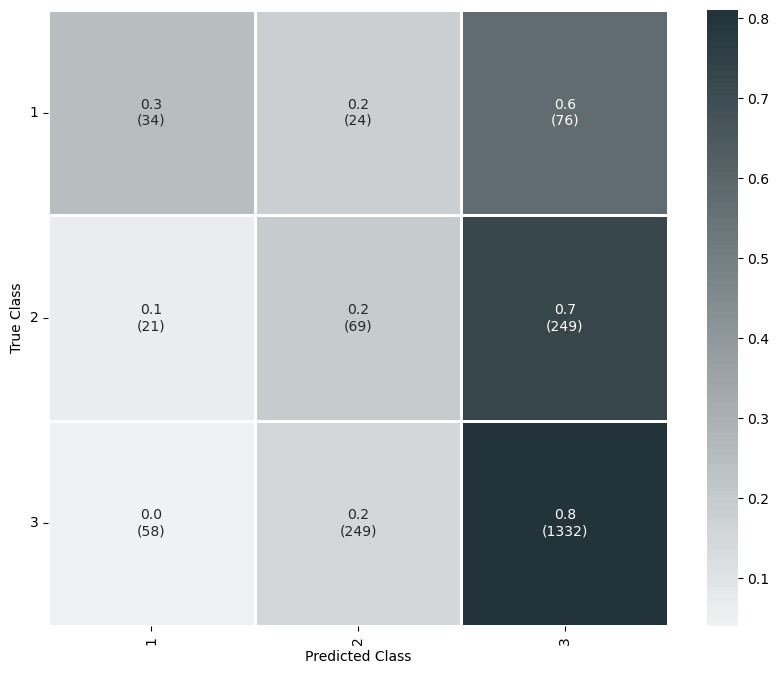

In [10]:
eval_utils.evaluate_cls(all_y_true, all_y_pred, [1,3])

              precision    recall  f1-score   support

           1       0.27      0.23      0.25       134
           2       0.23      0.23      0.23       339
           3       0.81      0.82      0.82      1639

    accuracy                           0.69      2112
   macro avg       0.44      0.43      0.43      2112
weighted avg       0.69      0.69      0.69      2112



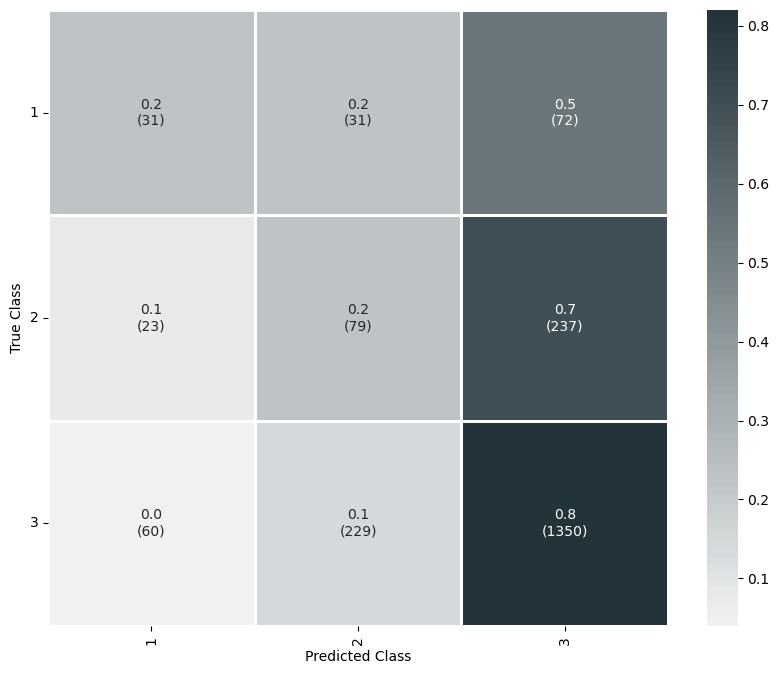

In [11]:
eval_utils.evaluate_cls(all_y_true, all_y_pred_asr, [1,3])

              precision    recall  f1-score   support

           1       0.22      0.22      0.22       134
           2       0.23      0.24      0.24       339
           3       0.82      0.82      0.82      1639

    accuracy                           0.69      2112
   macro avg       0.43      0.43      0.43      2112
weighted avg       0.69      0.69      0.69      2112



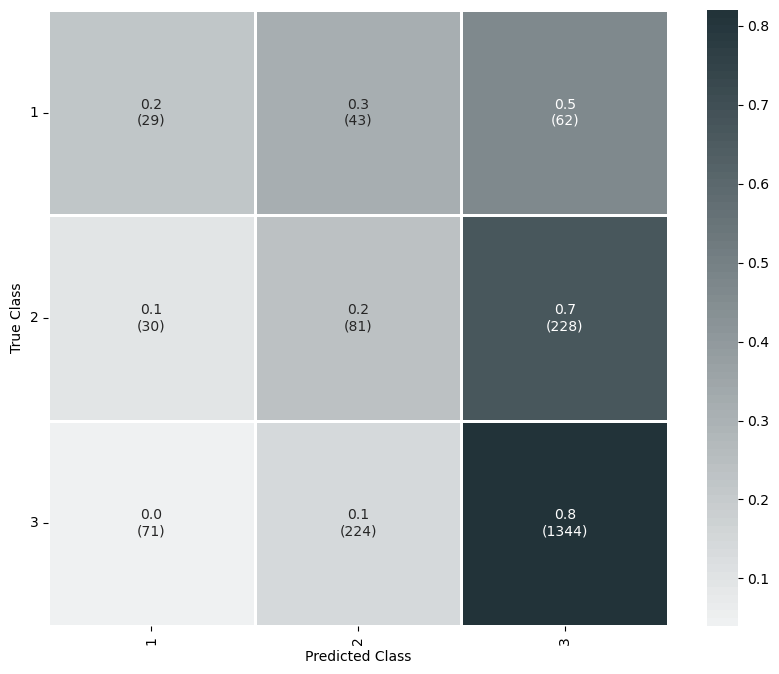

In [12]:
eval_utils.evaluate_cls(all_y_true, all_y_pred_centroid, [1,3])

              precision    recall  f1-score   support

           1       0.24      0.24      0.24       134
           2       0.25      0.25      0.25       339
           3       0.83      0.83      0.83      1639

    accuracy                           0.70      2112
   macro avg       0.44      0.44      0.44      2112
weighted avg       0.70      0.70      0.70      2112



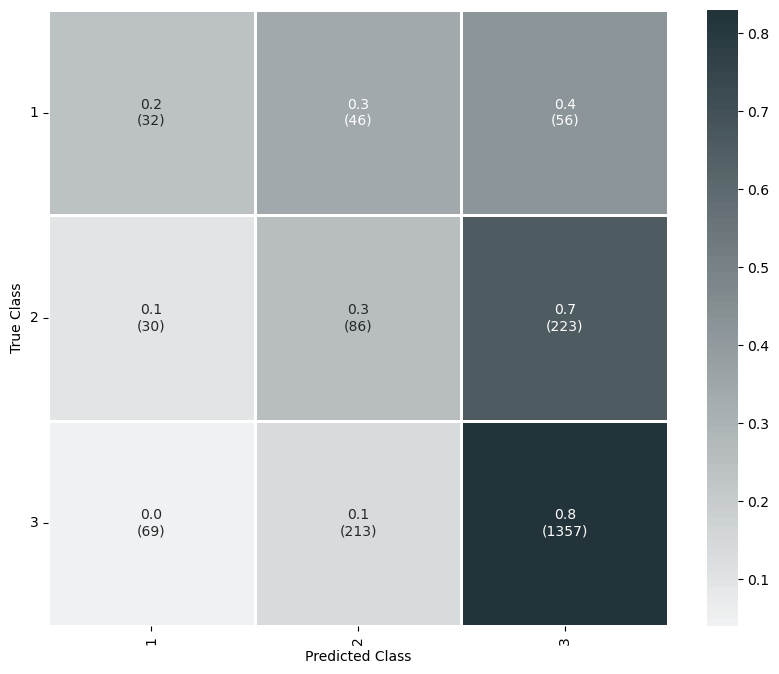

In [13]:
eval_utils.evaluate_cls(all_y_true, all_y_pred_asr_centroid, [1,3])

### TA as regression
* [x] MAE
* [x] correlation
* [x] kappa
* [x] prediction plot

### 1nn

MAE:  0.4323113952020202
MAE to cls:  0.3839962121212121
Correlation:  0.16960718137535483
Correlation cls:  0.1482824541390538
Kappa: 0.19628014062332477


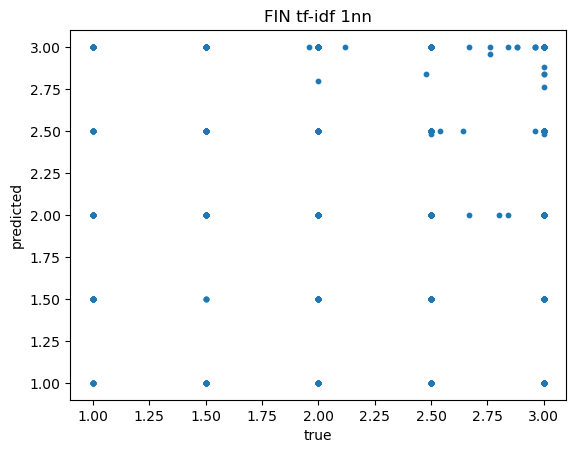

In [29]:
eval_utils.evaluate_reg(all_y_true, all_y_pred, "FIN tf-idf 1nn", [1,3])

MAE:  0.4197545770202021
MAE to cls:  0.3712121212121212
Correlation:  0.19881166460532843
Correlation cls:  0.18952615039346737
Kappa: 0.22028589122775133


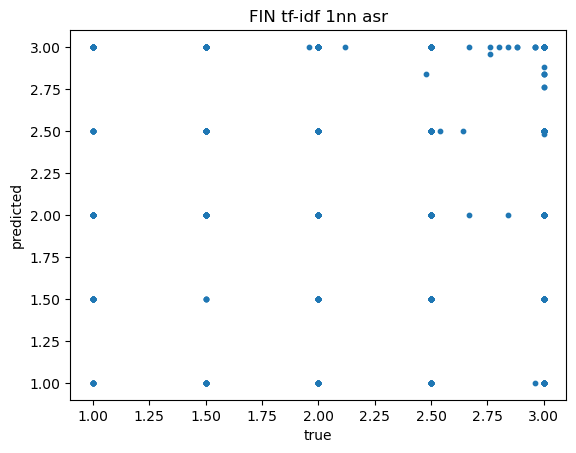

In [30]:
eval_utils.evaluate_reg(all_y_true, all_y_pred_asr, "FIN tf-idf 1nn asr", [1,3])

### centroids

MAE:  0.4302359532828283
MAE to cls:  0.37452651515151514
Correlation:  0.21292478776130283
Correlation cls:  0.22207936574285114
Kappa: 0.24148653938155085


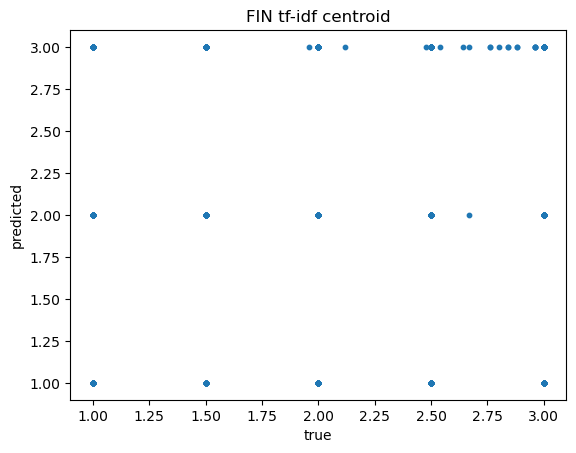

In [16]:
eval_utils.evaluate_reg(all_y_true, all_y_pred_centroid, "FIN tf-idf centroid", [1,3])

MAE:  0.41618923611111114
MAE to cls:  0.36079545454545453
Correlation:  0.25282055977764223
Correlation cls:  0.2546325388365962
Kappa: 0.27459875170969605


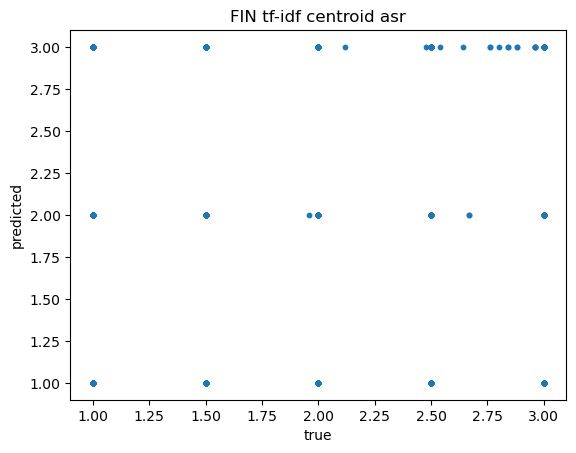

In [17]:
eval_utils.evaluate_reg(all_y_true, all_y_pred_asr_centroid, "FIN tf-idf centroid asr", [1,3])

### CLUSTERING
1. [x] TASKS
    * [x] average centroid distance
    * [x] cluster score
2. [x] SCORE BINS
    * [x] average centroid distance by task
        * [] per bin centroid
    * [x] cluster score by task
    * [x] mean av centroid distance
    * [x] mean cluster score by task


In [18]:
task_docs = get_task_docs(df, 'clean_transcript')
vectorizer = TfidfVectorizer(tokenizer=tok)
vectorizer.fit(task_docs)
vecs1 = vectorizer.transform(df['clean_transcript'])
vecs2 = vectorizer.transform(df['asr_transcript'])
df['tfidf_embeds'] = [v for v in vecs1.toarray()]
df['tfidf_asr_embeds'] = [v for v in vecs2.toarray()]

/share/apps/anaconda-ci/fgci-centos7-anaconda/software/anaconda/2022-04/18a3eb7e/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


### task scores

In [19]:
eval_utils.compute_task_scores(df, 'task', 'tfidf_embeds')

TASK CENTROID DISTANCE:  0.8852618869971013
CLUSTER SCORE: 17.541209341315014


In [20]:
eval_utils.compute_task_scores(df, 'task', 'tfidf_asr_embeds')

TASK CENTROID DISTANCE:  0.8811330162477319
CLUSTER SCORE: 19.981987167201815


### bin scores

In [21]:
eval_utils.compute_bin_scores(df, 'tfidf_embeds', 'ta_bins')

BIN DISTANCES:  0.46653176625026405
BIN CLUSTER SCORE:  1.191756179480103


In [22]:
eval_utils.compute_bin_scores(df, 'tfidf_asr_embeds', 'ta_bins')

BIN DISTANCES:  0.45842421765476077
BIN CLUSTER SCORE:  1.2603611236648022


### average bin scores
1. [] humam transcripts 

In [23]:
def get_score_centroids(df, embed_column):
    task_scores = {}
    task_centroid_distances = []
    for t in df['task'].unique():
        task_df = df[df['task']==t].copy()
        score_centroids = {}
        for b in task_df['ta_bins'].unique():
            bin_df = task_df[task_df['ta_bins']==b].copy()
            bin_embeddings = np.vstack(bin_df[embed_column])
            bin_centroid = np.array(bin_embeddings).mean(axis=0)
            score_centroids[b] = bin_centroid
        task_scores[t]=eval_utils.get_centroid_distances(score_centroids)['distance'].mean()
        task_centroid_distances.append(eval_utils.get_centroid_distances(score_centroids))
    return task_scores, task_centroid_distances

In [24]:
a, b = get_score_centroids(df, 'tfidf_embeds')

In [25]:
average_bin = {"1_2":0, "1_3":0, "2_3":0}
for task in b:
    for _, row in task.iterrows():
        l1 = row['label_1']
        l2 = row['label_2']
        dist = row['distance']
        labels = [int(l1),int(l2)]
        labels.sort()
        if str(labels[0])+"_"+str(labels[1]) == "1_2":
            average_bin["1_2"]+=dist
        elif str(labels[0])+"_"+str(labels[1]) == "1_3":
            average_bin["1_3"]+=dist
        else:
            average_bin["2_3"]+=dist

In [26]:
for key in average_bin.keys():
    average_bin[key] /= len(b)

In [27]:
average_bin

{'1_2': 0.5039286295132173,
 '1_3': 0.47296062612960005,
 '2_3': 0.30394115141577793}